In [ ]:
import scipy.io

In [ ]:
data = scipy.io.loadmat("/content/drive/MyDrive/dissertation/LearningData.mat")

## Exploration

In [ ]:
print(type(data))
print(data.keys())

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'rmat_post', 'rmat_pre', 'tMOT', 'tsamples', 'vmatpost', 'vmatpre'])


rmat_pre/post = dF/F signals for 8 mice and three stimuli (vertical, angled, gray corridor); vmatpre/post has the corresponding running speed signals; tsamples are the time samples for the calcium imaging; tMOT are the time samples for the running speed signal. Usually we only use a short segment of time around stimulus onset (e.g., -1 to 1 s), so not the full range of tsamples or tMOT.

In [ ]:
print(data['__header__'])
print(data['__version__'])
print(data['tMOT'].shape)

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Apr 19 08:22:01 2022'
1.0
(1, 3)


In [ ]:
print(data['tMOT'])
print(data['tMOT'][0][0][0], data['tMOT'][0][0][0].shape)

[[array([[-4.995, -4.99 , -4.985, ...,  4.985,  4.99 ,  4.995]])
  array([[-4.995, -4.99 , -4.985, ...,  4.985,  4.99 ,  4.995]])
  array([[-4.995, -4.99 , -4.985, ...,  4.985,  4.99 ,  4.995]])]]
[-4.995 -4.99  -4.985 ...  4.985  4.99   4.995] (1999,)


In [ ]:
print(data['tsamples'], data['tsamples'].shape)

[[-1.984 -1.86  -1.736 -1.612 -1.488 -1.364 -1.24  -1.116 -0.992 -0.868
  -0.744 -0.62  -0.496 -0.372 -0.248 -0.124  0.     0.124  0.248  0.372
   0.496  0.62   0.744  0.868  0.992  1.116  1.24   1.364  1.488  1.612
   1.736  1.86   1.984  2.108  2.232  2.356  2.48   2.604  2.728  2.852
   2.976  3.1    3.224  3.348  3.472  3.596  3.72   3.844  3.968  4.092
   4.216  4.34   4.464  4.588  4.712  4.836  4.96 ]] (1, 57)


8 mice

1st(pre) -> 3 stimuli vertical(78), angled(54), gray corridor(131) -> 138 neurons -> 57 timeframes 

Velocities recorded for timesteps in tMOT array

In [ ]:
y1 = np.array(data['rmat_pre'])
x1 = y1[0] #1,6 has no data
print(y1.shape)
print(x1.shape)
print(x1[0].shape)
print(x1[1].shape)
print(x1[2].shape)

(10, 3)
(3,)
(78, 138, 57)
(54, 138, 57)
(131, 138, 57)


In [ ]:
y2 = np.array(data['vmatpre'])
x2 = y2[0]
print(y2.shape)
print(x2.shape)
print(x2[0].shape)
print(x2[1].shape)
print(x2[2].shape)

(10, 3)
(3,)
(78, 1999)
(54, 1999)
(131, 1999)


8 mice

1st(post) -> 3 stimuli vertical(135), angled(120), gray corridor(254) -> 138 neurons -> 57 timeframes 

velocities recorded for timesteps in tMOT array(1999) 

In [ ]:
import numpy as np
y = np.array(data['rmat_post'])
x = y[0] #1,6(no data)
print(y.shape)
print(x.shape)
print(x[0].shape)
print(x[1].shape)
print(x[2].shape)

(10, 3)
(3,)
(135, 138, 57)
(120, 138, 57)
(254, 138, 57)


In [ ]:
y3 = np.array(data['vmatpost'])
x3 = y3[0]
print(y3.shape)
print(x3.shape)
print(x3[0].shape)
print(x3[1].shape)
print(x3[2].shape)

(10, 3)
(3,)
(135, 1999)
(120, 1999)
(254, 1999)


Questions:

1. Each neuron identity availability
2. Any other data is availble
3. Previous code for MVAR model if available
4. Feedback for IPP is plan valid or some changes required
5. Any specific things expected to work on 
6. How meetings work every week

# Data preparation

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
r1 = data['rmat_pre'][0]
print(r1.shape)

(3,)


In [ ]:
#create new dataset by combining all experiments for each animal
def create_dataset(exp):
  vertical = exp[0]
  new_v = np.take(vertical, list(range(8,25)), axis = 2) #taking values from -1 to 1 sec using tsamples array
  angled = exp[1]
  new_a = np.take(angled, list(range(8,25)), axis = 2) #taking values from -1 to 1 sec using tsamples array
  gray_corridor = exp[2]
  new_g = np.take(gray_corridor, list(range(8,25)), axis = 2) #taking values from -1 to 1 sec using tsamples array
  #creating y labels 0-vertical, 1-angled, 2-gray corridor
  y = [0 for i in range(new_v.shape[0])] + [1 for i in range(new_a.shape[0])] + [2 for i in range(new_g.shape[0])]
  combine = np.concatenate((new_v,new_a,new_g))
  #changing axis as required by lstm (samples, time, features)
  changed_axis = np.transpose(combine,axes = [0,2,1])
  return changed_axis,np.array(y)

In [ ]:
#finding nan values in X and dropping them
def remove_empty(X,y):
  print("total no of empty values in X = ",np.isnan(X).sum())
  print("old shape = ", X.shape, y.shape)
  trials_with_nan = []
  for ind,i in enumerate(X):
    if np.isnan(i).sum()!=0:
      print("trail = ", ind, " empty values = ", np.isnan(i).sum())
      trials_with_nan.append(ind)
  X = np.delete(X, trials_with_nan, axis = 0) #dropping the trials with empty values from the dataset
  y = np.delete(y, trials_with_nan)
  print("new X shape = ", X.shape,y.shape)
  return X,y

In [ ]:
#normalizing by finding max and minimum for all neurons in later part can try based on cell type
def normalize(X,y):
  xmax,xmin = np.max(X.flatten()),np.min(X.flatten())
  print(xmax,xmin)
  fun = lambda t: (t-xmin)/(xmax-xmin)
  xfun = np.vectorize(fun)
  x = xfun(X)
  return x,y

In [ ]:
X,y = create_dataset(r1)

In [ ]:
print(X.shape,y.shape)

(263, 17, 138) (263,)


In [ ]:
X,y = remove_empty(X,y)
print(np.isnan(X).sum())

total no of empty values in X =  2686
old shape =  (263, 17, 138) (263,)
trail =  37  empty values =  441
trail =  229  empty values =  2245
new X shape =  (261, 17, 138) (261,)
0


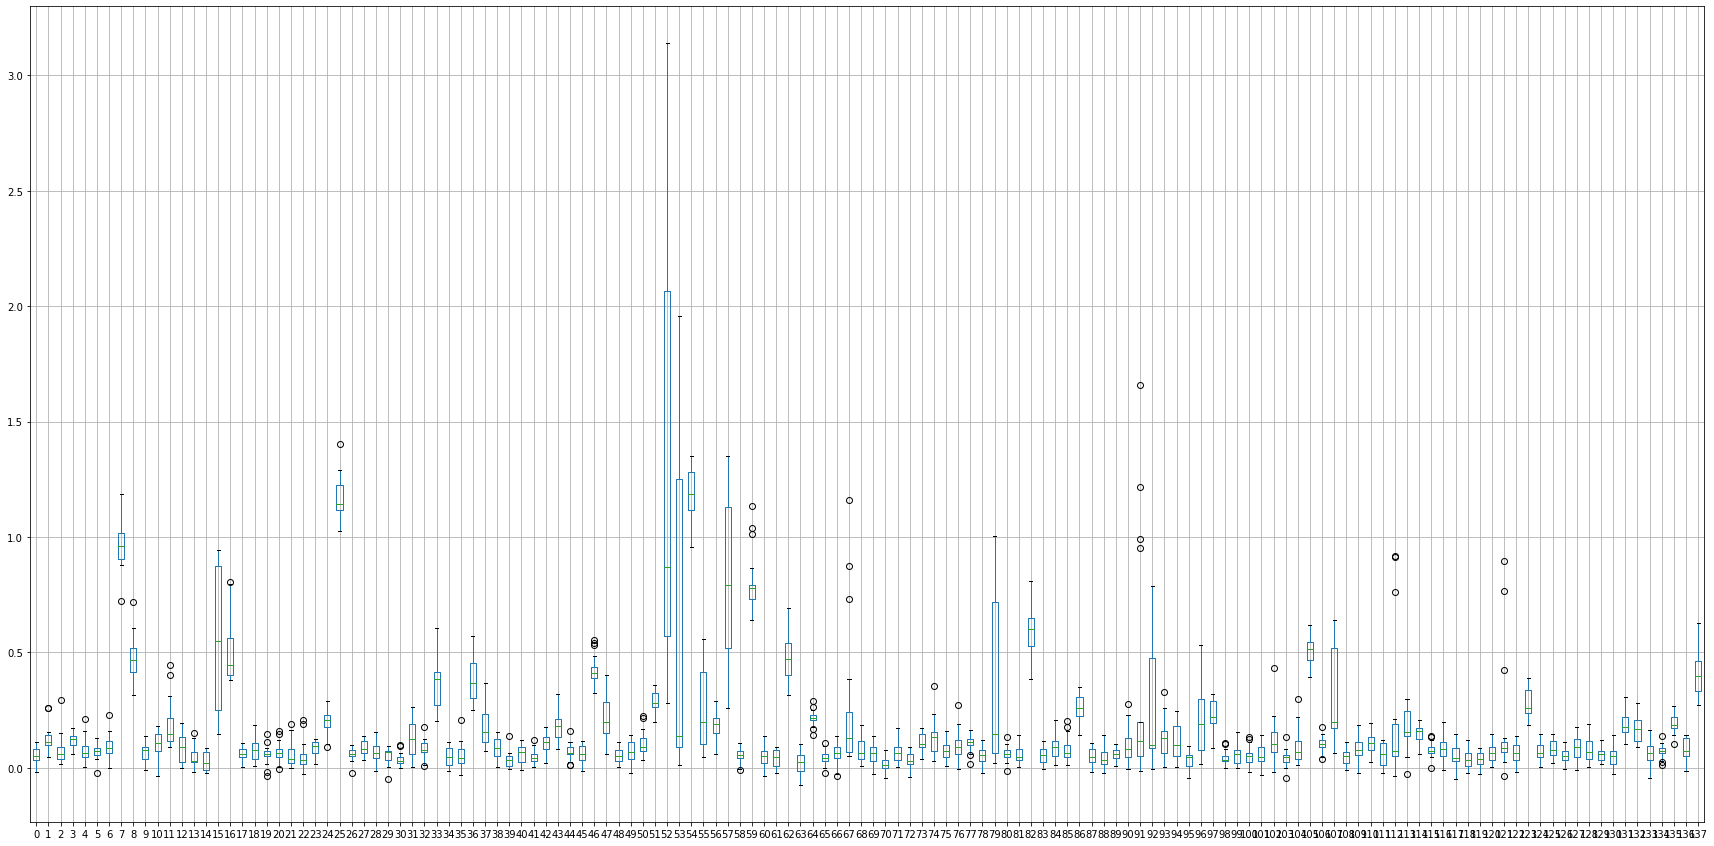

In [ ]:
plt.rcParams["figure.figsize"] = (30,15)
l = pd.DataFrame(X[0])
l.boxplot()
plt.show()

In [ ]:
ma,mi = np.max(X.flatten()),np.min(X.flatten())
print(ma)
j = np.where(X == ma)
print(j)
k = np.where(X == mi)
print(k)

6.1336303
(array([46]), array([9]), array([78]))
(array([226]), array([13]), array([76]))


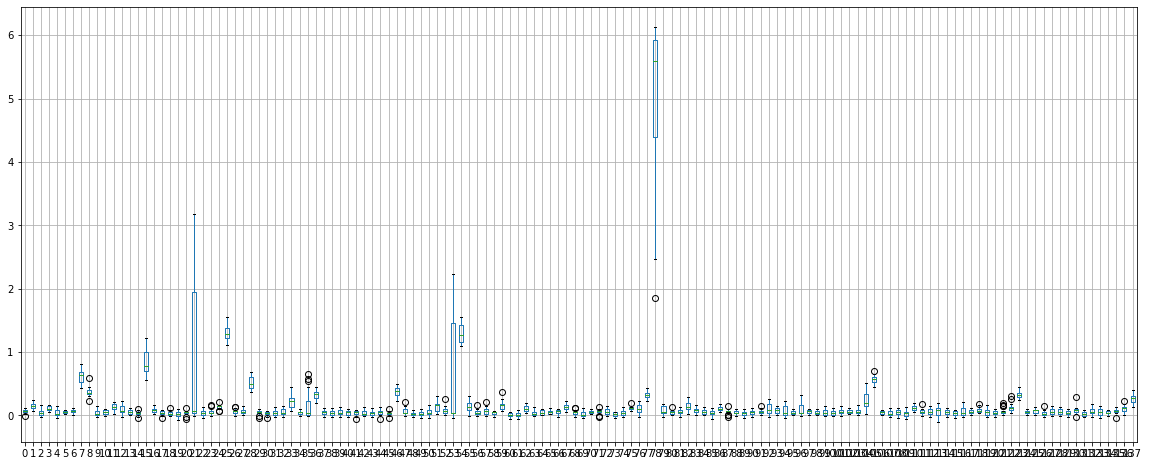

In [ ]:
m = pd.DataFrame(X[46])
m.boxplot()
plt.show()

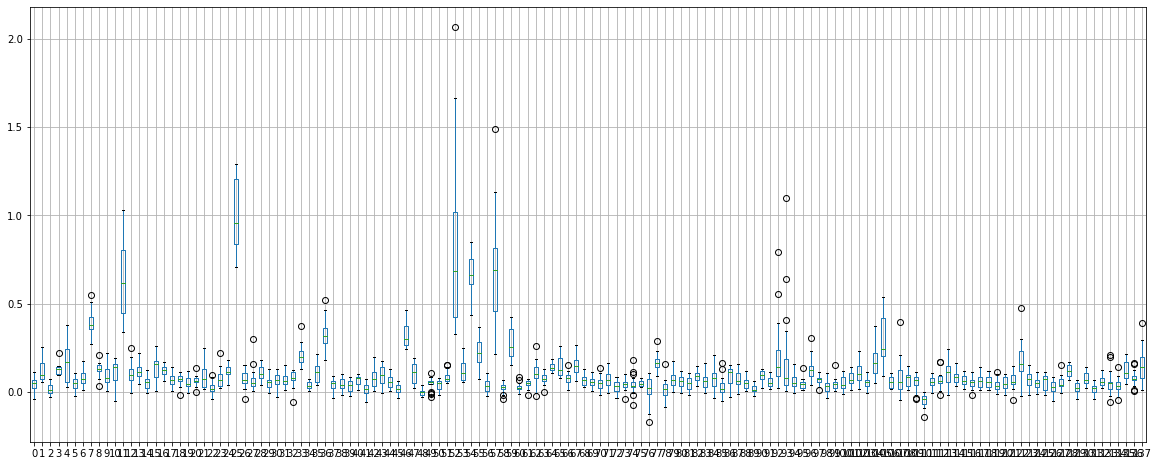

In [ ]:
m = pd.DataFrame(X[226])
m.boxplot()
plt.show()

In [ ]:
#normalizing values between 0 and 1
X,y = normalize(X,y)

6.1336303 -0.16922076


In [ ]:
print(X.shape,y.shape)

(261, 17, 138) (261,)


In [ ]:
  np.save("/content/drive/MyDrive/dissertation/rat1_X",X)
  np.save("/content/drive/MyDrive/dissertation/rat1_y",y)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1, random_state = 8)
X_trn,X_val,y_trn,y_val = train_test_split(X_train,y_train,test_size = 0.1, random_state = 8)
print(X_trn.shape,X_val.shape,X_test.shape)

(210, 17, 138) (24, 17, 138) (27, 17, 138)


In [ ]:
def new_dataset(r):
  X,y = create_dataset(r)
  X,y = remove_empty(X,y)
  X,y = normalize(X,y)
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1, random_state = 8)
  X_trn,X_val,y_trn,y_val = train_test_split(X_train,y_train,test_size = 0.1, random_state = 8)
  return X_trn,X_val,X_test,y_trn,y_val,y_test

In [ ]:
r2 = data['rmat_pre'][2]
X_trn,X_val,X_test,y_trn,y_val,y_test = new_dataset(r2)

total no of empty values in X =  684
old shape =  (279, 17, 110) (279,)
trail =  31  empty values =  53
trail =  95  empty values =  550
trail =  152  empty values =  81
new X shape =  (276, 17, 110) (276,)
4.62151 -0.13612801


### model creation for r[0]

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras import layers,models

In [ ]:
def create_model(units,units1,activation):
  input_shape = (17,138) #17 timestamps and 138 features
  basic_lstm = Sequential()
  basic_lstm.add(LSTM(units=units,input_shape = input_shape))
  basic_lstm.add(Dense(units = units1,activation = activation))
  basic_lstm.add(Dense(3,activation = 'softmax'))
  return basic_lstm

In [ ]:
lstm_1 = create_model(units = 22,units1 = 13,activation='relu')
lstm_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 22)                14168     
                                                                 
 dense (Dense)               (None, 13)                299       
                                                                 
 dense_1 (Dense)             (None, 3)                 42        
                                                                 
Total params: 14,509
Trainable params: 14,509
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=5)
l = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate= 0.0022556)
lstm_1.compile(loss= l, optimizer = opt,metrics=['accuracy'])
history = lstm_1.fit(X_trn,y_trn,batch_size = 32,epochs = 50,verbose = 2,steps_per_epoch = X_trn.shape[0]/50,validation_data=(X_val,y_val))

Epoch 1/50
4/4 - 3s - loss: 1.0667 - accuracy: 0.5500 - val_loss: 0.9728 - val_accuracy: 0.5833 - 3s/epoch - 727ms/step
Epoch 2/50
4/4 - 0s - loss: 1.0100 - accuracy: 0.5205 - val_loss: 0.8977 - val_accuracy: 0.5833 - 72ms/epoch - 17ms/step
Epoch 3/50
4/4 - 0s - loss: 0.9636 - accuracy: 0.5000 - val_loss: 0.8511 - val_accuracy: 0.6667 - 81ms/epoch - 19ms/step
Epoch 4/50
4/4 - 0s - loss: 0.9403 - accuracy: 0.6313 - val_loss: 0.7891 - val_accuracy: 0.7917 - 76ms/epoch - 18ms/step
Epoch 5/50
4/4 - 0s - loss: 0.8070 - accuracy: 0.6918 - val_loss: 0.6579 - val_accuracy: 0.7500 - 74ms/epoch - 18ms/step
Epoch 6/50
4/4 - 0s - loss: 0.7619 - accuracy: 0.7055 - val_loss: 0.5346 - val_accuracy: 0.8750 - 72ms/epoch - 17ms/step
Epoch 7/50
4/4 - 0s - loss: 0.6485 - accuracy: 0.7123 - val_loss: 0.4738 - val_accuracy: 0.8333 - 83ms/epoch - 20ms/step
Epoch 8/50
4/4 - 0s - loss: 0.5494 - accuracy: 0.7563 - val_loss: 0.3571 - val_accuracy: 0.8333 - 74ms/epoch - 18ms/step
Epoch 9/50
4/4 - 0s - loss: 0.535

## lstm_1

In [ ]:
m = history.history

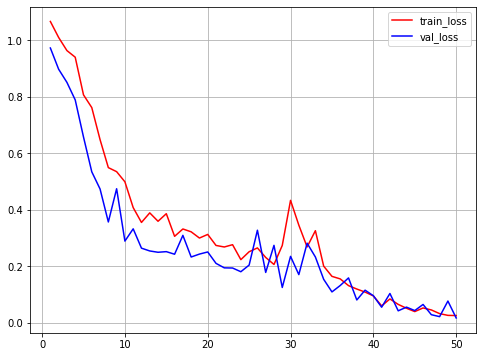

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
epochs = list(range(1,51))
plt.plot(epochs,m['loss'],'r',label = 'train_loss')
plt.plot(epochs,m['val_loss'],'b',label = 'val_loss')
plt.grid()
plt.legend()
plt.show()

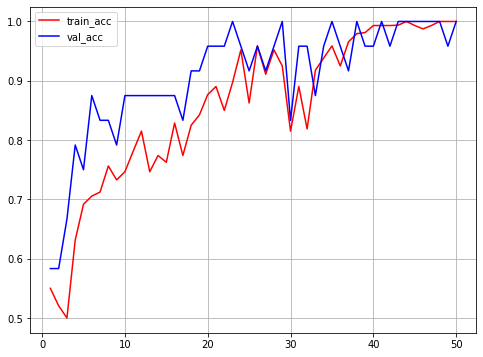

In [ ]:
plt.plot(epochs,m['accuracy'],'r',label = 'train_acc')
plt.plot(epochs,m['val_accuracy'],'b',label = 'val_acc')
plt.grid()
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = lstm_1.predict(X_test,batch_size = 1)
#print(y_pred)

In [ ]:
from sklearn.metrics import accuracy_score
ypred = np.argmax(y_pred,axis=1)
accuracy_score(y_test,ypred)

0.8888888888888888

In [ ]:
lstm_1.save("/content/drive/MyDrive/dissertation/time_series_classification/baseline_lstm1.h5")

## lstm2

In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=5)
lstm_2 = create_model(12,5,'tanh')
l = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate =  0.003468)
lstm_2.compile(loss= l, optimizer = opt,metrics=['accuracy'])
history_2 = lstm_2.fit(X_trn,y_trn,batch_size = 32,epochs = 50,verbose = 2,steps_per_epoch = X_trn.shape[0]/50,validation_data=(X_val,y_val))

Epoch 1/50
4/4 - 3s - loss: 1.0579 - accuracy: 0.4938 - val_loss: 0.9397 - val_accuracy: 0.5833 - 3s/epoch - 642ms/step
Epoch 2/50
4/4 - 0s - loss: 1.0202 - accuracy: 0.4932 - val_loss: 0.9248 - val_accuracy: 0.5833 - 71ms/epoch - 17ms/step
Epoch 3/50
4/4 - 0s - loss: 1.0476 - accuracy: 0.4726 - val_loss: 0.9181 - val_accuracy: 0.5833 - 70ms/epoch - 17ms/step
Epoch 4/50
4/4 - 0s - loss: 1.0007 - accuracy: 0.4875 - val_loss: 0.9158 - val_accuracy: 0.5833 - 75ms/epoch - 18ms/step
Epoch 5/50
4/4 - 0s - loss: 0.9868 - accuracy: 0.4795 - val_loss: 0.8763 - val_accuracy: 0.5833 - 69ms/epoch - 16ms/step
Epoch 6/50
4/4 - 0s - loss: 0.9520 - accuracy: 0.5068 - val_loss: 0.8048 - val_accuracy: 0.7083 - 69ms/epoch - 16ms/step
Epoch 7/50
4/4 - 0s - loss: 0.8208 - accuracy: 0.6918 - val_loss: 0.6858 - val_accuracy: 0.8333 - 79ms/epoch - 19ms/step
Epoch 8/50
4/4 - 0s - loss: 0.7068 - accuracy: 0.7812 - val_loss: 0.5458 - val_accuracy: 0.8333 - 70ms/epoch - 17ms/step
Epoch 9/50
4/4 - 0s - loss: 0.649

In [ ]:
m = history_2.history

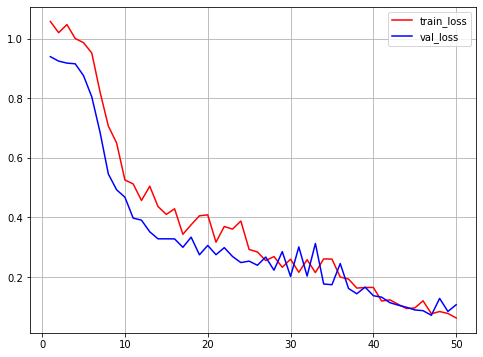

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
epochs = list(range(1,51))
plt.plot(epochs,m['loss'],'r',label = 'train_loss')
plt.plot(epochs,m['val_loss'],'b',label = 'val_loss')
plt.grid()
plt.legend()
plt.show()

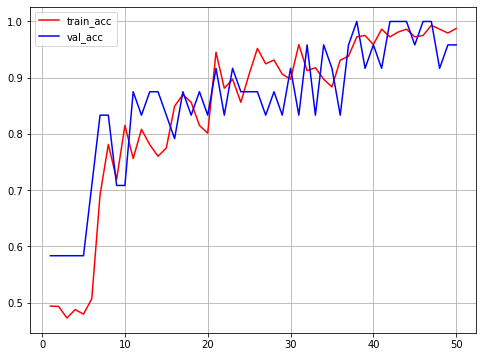

In [ ]:
plt.plot(epochs,m['accuracy'],'r',label = 'train_acc')
plt.plot(epochs,m['val_accuracy'],'b',label = 'val_acc')
plt.grid()
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = lstm_2.predict(X_test,batch_size = 1)
ypred = np.argmax(y_pred,axis=1)
accuracy_score(y_test,ypred)

0.9629629629629629

In [ ]:
lstm_2.save("/content/drive/MyDrive/dissertation/time_series_classification/baseline_lstm2.h5")

## lstm3

In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=5)
lstm_3 = create_model(10,10,'sigmoid')
l = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate =  0.00709)
lstm_3.compile(loss= l, optimizer = opt,metrics=['accuracy'])
history_3 = lstm_3.fit(X_trn,y_trn,batch_size = 32,epochs = 50,verbose = 2,steps_per_epoch = X_trn.shape[0]/50,validation_data=(X_val,y_val))

Epoch 1/50
4/4 - 3s - loss: 1.0539 - accuracy: 0.4437 - val_loss: 0.9607 - val_accuracy: 0.5833 - 3s/epoch - 623ms/step
Epoch 2/50
4/4 - 0s - loss: 1.0117 - accuracy: 0.5274 - val_loss: 0.9394 - val_accuracy: 0.5833 - 67ms/epoch - 16ms/step
Epoch 3/50
4/4 - 0s - loss: 1.0438 - accuracy: 0.4658 - val_loss: 0.9259 - val_accuracy: 0.5833 - 72ms/epoch - 17ms/step
Epoch 4/50
4/4 - 0s - loss: 1.0025 - accuracy: 0.4750 - val_loss: 0.8640 - val_accuracy: 0.5833 - 84ms/epoch - 20ms/step
Epoch 5/50
4/4 - 0s - loss: 0.9196 - accuracy: 0.5616 - val_loss: 0.7825 - val_accuracy: 0.7917 - 80ms/epoch - 19ms/step
Epoch 6/50
4/4 - 0s - loss: 0.9224 - accuracy: 0.6575 - val_loss: 0.6709 - val_accuracy: 0.8750 - 81ms/epoch - 19ms/step
Epoch 7/50
4/4 - 0s - loss: 0.6938 - accuracy: 0.7945 - val_loss: 0.6070 - val_accuracy: 0.8333 - 80ms/epoch - 19ms/step
Epoch 8/50
4/4 - 0s - loss: 0.6377 - accuracy: 0.7625 - val_loss: 0.5296 - val_accuracy: 0.8333 - 70ms/epoch - 17ms/step
Epoch 9/50
4/4 - 0s - loss: 0.903

In [ ]:
m = history_3.history

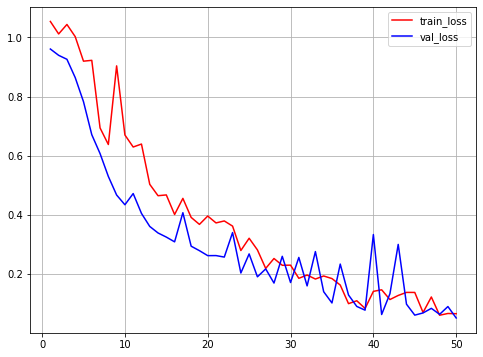

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
epochs = list(range(1,51))
plt.plot(epochs,m['loss'],'r',label = 'train_loss')
plt.plot(epochs,m['val_loss'],'b',label = 'val_loss')
plt.grid()
plt.legend()
plt.show()

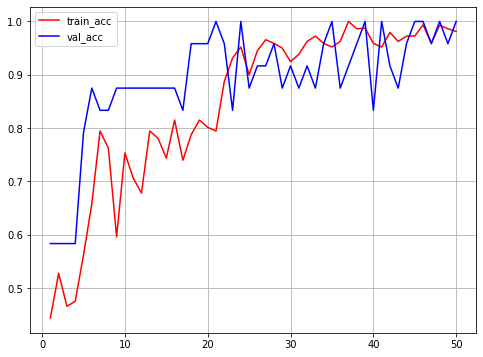

In [ ]:
plt.plot(epochs,m['accuracy'],'r',label = 'train_acc')
plt.plot(epochs,m['val_accuracy'],'b',label = 'val_acc')
plt.grid()
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = lstm_3.predict(X_test,batch_size = 1)
ypred = np.argmax(y_pred,axis=1)
accuracy_score(y_test,ypred)

1.0

In [ ]:
lstm_3.save("/content/drive/MyDrive/dissertation/time_series_classification/baseline_lstm3.h5")

In [ ]:
np.save("/content/drive/MyDrive/dissertation/Xtrn",X_trn)

In [ ]:
np.save("/content/drive/MyDrive/dissertation/Xtrn",X_val)
np.save("/content/drive/MyDrive/dissertation/Xtrn",X_test)

## Using keras tuner for hyperparameter tuning

In [ ]:
!pip install keras-tuner -q

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [ ]:
import keras_tuner
def call_model(units, units1, activation, lr):
    inp_shape = (17,138) #17 timestamps and 138 features
    model = keras.Sequential()
    model.add(LSTM(units = units,input_shape = inp_shape)) #try using return_sequences = True if possible.
    model.add(layers.Dense(units=units1, activation=activation))
    model.add(layers.Dense(3, activation="softmax"))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_model(hp):
    units = hp.Int("units", min_value=10, max_value=25, step=2)
    units1 = hp.Int("units1",min_value = 5,max_value = 15, step = 1)
    activation = hp.Choice("activation", ["relu", "tanh","sigmoid"])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_model(units=units, units1 = units1, activation=activation, lr=lr)
    return model


build_model(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=15,
    executions_per_trial=1,
    overwrite=True,
    directory="/content/drive/MyDrive/dissertation/results_dir",
    project_name="/content/drive/MyDrive/dissertation_results",
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 25, 'step': 2, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 15, 'step': 1, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(X_trn, y_trn, epochs=50, validation_data=(X_val, y_val))

Trial 15 Complete [00h 00m 13s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 03m 13s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(17, 138))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22)                14168     
                                                                 
 dense (Dense)               (None, 13)                299       
                                                                 
 dense_1 (Dense)             (None, 3)                 42        
                                                                 
Total params: 14,509
Trainable params: 14,509
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/dissertation_results
Showing 10 best trials
Trial summary
Hyperparameters:
units: 22
units1: 13
activation: relu
lr: 0.0022556211284225536
Score: 1.0
Trial summary
Hyperparameters:
units: 12
units1: 5
activation: tanh
lr: 0.0034681885165451717
Score: 1.0
Trial summary
Hyperparameters:
units: 10
units1: 10
activation: sigmoid
lr: 0.007098325702001617
Score: 1.0
Trial summary
Hyperparameters:
units: 20
units1: 9
activation: tanh
lr: 0.0021765065892749877
Score: 1.0
Trial summary
Hyperparameters:
units: 24
units1: 5
activation: tanh
lr: 0.000989402078616141
Score: 1.0
Trial summary
Hyperparameters:
units: 16
units1: 12
activation: sigmoid
lr: 0.004485708249434565
Score: 1.0
Trial summary
Hyperparameters:
units: 12
units1: 7
activation: tanh
lr: 0.004384151266566465
Score: 1.0
Trial summary
Hyperparameters:
units: 16
units1: 13
activation: tanh
lr: 0.00727915929887585
Score: 1.0
Trial summary
Hyperparameters:
units: 14
units1: 11
activation

In [ ]:
l = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate = 0.0022556)
best_model.compile(loss= l, optimizer = opt,metrics=['accuracy'])
history = best_model.fit(X_trn,y_trn,batch_size = 32,epochs = 50,verbose = 2,steps_per_epoch = X_trn.shape[0]/50,validation_data=(X_val,y_val))

Epoch 1/50
4/4 - 3s - loss: 0.3633 - accuracy: 0.8625 - val_loss: 0.1943 - val_accuracy: 1.0000 - 3s/epoch - 608ms/step
Epoch 2/50
4/4 - 0s - loss: 0.2781 - accuracy: 0.9384 - val_loss: 0.2129 - val_accuracy: 0.9167 - 67ms/epoch - 16ms/step
Epoch 3/50
4/4 - 0s - loss: 0.2666 - accuracy: 0.9315 - val_loss: 0.1883 - val_accuracy: 0.9583 - 66ms/epoch - 16ms/step
Epoch 4/50
4/4 - 0s - loss: 0.2212 - accuracy: 0.9500 - val_loss: 0.1494 - val_accuracy: 0.9583 - 69ms/epoch - 16ms/step
Epoch 5/50
4/4 - 0s - loss: 0.2369 - accuracy: 0.8699 - val_loss: 0.1506 - val_accuracy: 1.0000 - 73ms/epoch - 17ms/step
Epoch 6/50
4/4 - 0s - loss: 0.2020 - accuracy: 0.9589 - val_loss: 0.1826 - val_accuracy: 0.9583 - 64ms/epoch - 15ms/step
Epoch 7/50
4/4 - 0s - loss: 0.1766 - accuracy: 0.9589 - val_loss: 0.1204 - val_accuracy: 0.9583 - 63ms/epoch - 15ms/step
Epoch 8/50
4/4 - 0s - loss: 0.1572 - accuracy: 0.9688 - val_loss: 0.1057 - val_accuracy: 1.0000 - 67ms/epoch - 16ms/step
Epoch 9/50
4/4 - 0s - loss: 0.136

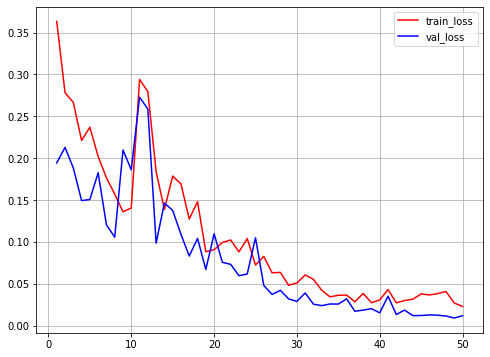

In [ ]:
m = history.history
plt.rcParams["figure.figsize"] = (8,6)
epochs = list(range(1,51))
plt.plot(epochs,m['loss'],'r',label = 'train_loss')
plt.plot(epochs,m['val_loss'],'b',label = 'val_loss')
plt.grid()
plt.legend()
plt.show()

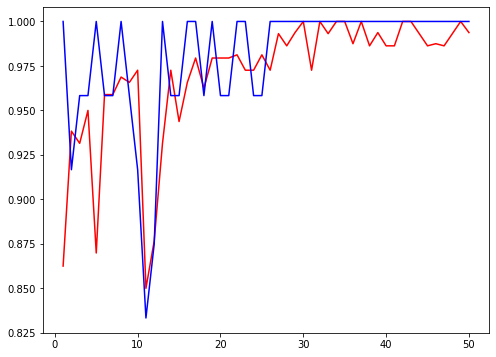

In [ ]:
plt.plot(epochs,m['accuracy'],'r')
plt.plot(epochs,m['val_accuracy'],'b')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = best_model.predict(X_test,batch_size = 1)
ypred = np.argmax(y_pred,axis=1)
accuracy_score(y_test,ypred)

0.9629629629629629

## Using SHAP for analysis

In [ ]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.2 MB/s 


In [ ]:
explainer = shap.DeepExplainer(best_model, X_trn)
shap_values = explainer.shap_values(X_test)
shap.initjs()

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: ignored

1. Is the normalization correct or any other method used?
2. -1 to 1 = 17 timesteps how to partition next timsteps for time series classification?
3. max and min values vary for each sample is this expected or there are any outliers.
4. lstm gives good generalization and accuracy but will test for all other data as well.
*next steps:*
1. To see if all rats have same feature representation if yes can train model with all samples available
2. Work on time series prediction model

## model creation for r[2]

In [ ]:
def create_model(inp_shape):
  input_shape = inp_shape #17 timestamps and n features
  model = Sequential()
  model.add(LSTM(12,input_shape = input_shape))
  model.add(Dense(8,activation = 'tanh'))
  model.add(Dense(3,activation = 'softmax'))
  print(model.summary())
  return model
  

# Extras

In [ ]:
#create new dataset by combining all experiments for each animal
def create_new(r):
  new_r = []
  for i,exp in enumerate(r):
    #print("experiment {} with shape".format(i),exp.shape)
    for j,trail in enumerate(exp):
      #print("trail {}".format(j), trail.shape)
      time = list(range(1,18))
      for k,neuron in enumerate(trail):
        x = neuron[8:25] #taking values from -1 to 1 sec using tsamples array
        #adding experiment type as categorical variable at the end 
        x = np.append(x,[i])
        new_r.append(x)
  #print(len(new_r))
  return np.array(new_r)

In [ ]:
new_r1,y = create_new(r1)
print(new_r1.shape)
changed_axis = np.transpose(new_r1,axes = [0,2,1])
print(changed_axis.shape)

(263, 138, 17)
(263, 17, 138)


In [ ]:
new_v,new_a,new_g = np.zeros(shape= (78,17,138)),np.zeros(shape= (78,17,138)),np.zeros(shape= (78,17,138))
y = [0 for i in range(new_v.shape[0])] + [1 for i in range(new_a.shape[0])] + [2 for i in range(new_g.shape[0])]
print(len(y))
print(y[77])

234
0


In [ ]:
normalized = tf.keras.layers.Normalization(axis = None)
normalized.adapt(X)
norm_x = normalized(X)
print(norm_x.shape)

(261, 17, 138)
